## Regularization in Regression

In this section, we will address the main challenges in regression problems and discuss how regularization helps to alleviate these issues.

### Resolving Non-Uniqueness

In regression problems, the normal equations might have infinitely many solutions, especially when the design matrix $\mathbf{X}$ is rank-deficient. To resolve the non-uniqueness, we can use $\ell_2$-regularization (Ridge Regression):

$$
\mathbf{w}_{\text{reg}}^* = \arg\min_{\mathbf{w}} \left( \frac{1}{N} \sum_{n=1}^{N} \left( y_n - \mathbf{x}_n^T \mathbf{w} \right)^2 + \lambda \|\mathbf{w}\|_2^2 \right)
$$

where $\lambda > 0$ is the regularization factor. The solution is unique and given by:

$$
\mathbf{w}_{\text{reg}}^* = (\lambda N \mathbf{I} + \mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

### Promoting Smaller Solutions

Regularization also promotes solutions with smaller Euclidean norms, which helps in controlling the model complexity. In the case of Ridge Regression, the regularization term $\lambda \|\mathbf{w}\|_2^2$ biases the solution towards smaller norms.

$$
\lambda \|\mathbf{w}_{\text{reg}}\|_2^2 + \frac{1}{N} \sum_{n=1}^{N} \left( y_n - \mathbf{x}_n^T \mathbf{w}_{\text{reg}} \right)^2 \leq \lambda \|\mathbf{w}\|_2^2 + \frac{1}{N} \sum_{n=1}^{N} \left( y_n - \mathbf{x}_n^T \mathbf{w} \right)^2
$$

This ensures that:

$$
\|\mathbf{w}_{\text{reg}}\|_2^2 \leq \|\mathbf{w}\|_2^2
$$

### Countering Ill-Conditioning

Ill-conditioning occurs when small changes in the data can cause large changes in the solution. Ridge Regression helps counter this by improving the condition number of the matrix to be inverted:

$$
\kappa(\lambda N \mathbf{I} + \mathbf{X}^T \mathbf{X}) = \frac{\lambda N + \sigma_{\max}^2 (\mathbf{X})}{\lambda N + \sigma_{\min}^2 (\mathbf{X})}
$$

where $\sigma_{\max}$ and $\sigma_{\min}$ are the largest and smallest singular values of $\mathbf{X}$.

### Countering Overfitting

Regularization helps in countering overfitting by limiting the complexity of the model. Ridge Regression achieves this by constraining the search space for $\mathbf{w}$:

$$
\mathbf{w}_{\text{reg}}^* = \arg\min_{\mathbf{w}} \left( \frac{1}{N} \sum_{n=1}^{N} \left( y_n - \mathbf{x}_n^T \mathbf{w} \right)^2 \right), \text{subject to } \lambda \|\mathbf{w}\|_2 \leq \tau
$$

This prevents the model from fitting the noise in the training data, thus improving generalization to new data.

### QR Method for Minimizing $\ell_2$-Regularized Least-Squares Risk

To compute the regularized solution efficiently, we can use the QR decomposition. Here's the algorithm:

**QR Method for Minimizing $\ell_2$-Regularized Least-Squares Risk**

1. Given $\lambda > 0$ and data $\mathbf{y} = \text{col}\{y_n\}, \mathbf{X} = \text{blkrow}\{\mathbf{x}_n^T\}$,
2. Construct $\mathbf{X}_e = \begin{pmatrix} \mathbf{X} \\ \sqrt{\lambda N} \mathbf{I} \end{pmatrix}$ and $\mathbf{y}_e = \begin{pmatrix} \mathbf{y} \\ \mathbf{0}_{M \times 1} \end{pmatrix}$,
3. Perform the QR decomposition $\mathbf{X}_e = \mathbf{Q} \begin{pmatrix} \mathbf{R} \\ \mathbf{0} \end{pmatrix}$,
4. Apply $\mathbf{Q}^T$ to $\mathbf{y}_e$ and find $\mathbf{Q}^T \mathbf{y}_e = \begin{pmatrix} \mathbf{d} \\ \mathbf{\Psi} \end{pmatrix}$,
5. Solve the triangular system of equations $\mathbf{R} \mathbf{w}_{\text{reg}}^* = \mathbf{d}$.

This method avoids numerical issues associated with directly inverting the matrix $\lambda N \mathbf{I} + \mathbf{X}^T \mathbf{X}$.

In [17]:
# Modify from https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_coeffs.html#sphx-glr-auto-examples-linear-model-plot-ridge-coeffs-py

import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.linalg import solve_triangular
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.datasets import make_regression

# Example usage with sklearn pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


class QRidge(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0, random_state=None):
        """
        Custom Ridge Regression using QR factorization.
        
        Parameters:
            alpha (float): Regularization strength; must be a positive float.
            random_state (int or None): Seed for the random number generator.
        """
        self.alpha = alpha
        self.random_state = random_state
        self.coef_ = None
    
    def fit(self, X, y):
        """
        Fit the Ridge Regression model using QR factorization.
        
        Parameters:
            X (array-like): Training data of shape (n_samples, n_features).
            y (array-like): Target values of shape (n_samples,).
        
        Returns:
            self: Returns an instance of self.
        """
        X = jnp.asarray(X)
        y = jnp.asarray(y)
        n, p = X.shape
        I = jnp.eye(p)
        sqrt_alpha_I = jnp.sqrt(self.alpha) * I
        
        # Augment X and y for the regularization term
        X_aug = jnp.vstack((X, sqrt_alpha_I))
        y_aug = jnp.hstack((y, jnp.zeros(p)))
        
        # Perform QR factorization
        Q, R = jnp.linalg.qr(X_aug)
        
        # Solve the system R * w = Q.T * y_aug
        QTy = jnp.dot(Q.T, y_aug)
        self.coef_ = solve_triangular(R, QTy, lower=False)
        
        return self
    
    def predict(self, X):
        """
        Predict using the Ridge Regression model.
        
        Parameters:
            X (array-like): Samples of shape (n_samples, n_features).
        
        Returns:
            y_pred (array-like): Predicted values of shape (n_samples,).
        """
        X = jnp.asarray(X)
        return jnp.dot(X, self.coef_)


# Create a pipeline with standard scaling and custom Ridge Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', QRidge(alpha=0.8, random_state=0))
])

# Example data
X, y, w = make_regression(
    n_samples=100, n_features=10, n_informative=8, coef=True, random_state=1
)

# Fit the pipeline
pipeline.fit(X, y)

# Predict using the pipeline
predictions = pipeline.predict(X)
print(f"MSE: {mean_squared_error(predictions, y)}")

jnp.set_printoptions(precision=3, suppress=True)

# Obtain the true coefficients
print(f"The estimated coefficient of this regression problem are:\n{pipeline.named_steps['ridge'].coef_}\n")
print(f"The true coefficient of this regression problem are:\n{w}")


MSE: 797.6303452280235
The estimated coefficient of this regression problem are:
[37.927 85.252 -0.013 30.038 -0.049 17.426 26.289 35.696 47.786 70.416]

The true coefficient of this regression problem are:
[38.326 88.497  0.    29.757  0.    19.087 25.444 38.699 49.288 71.759]


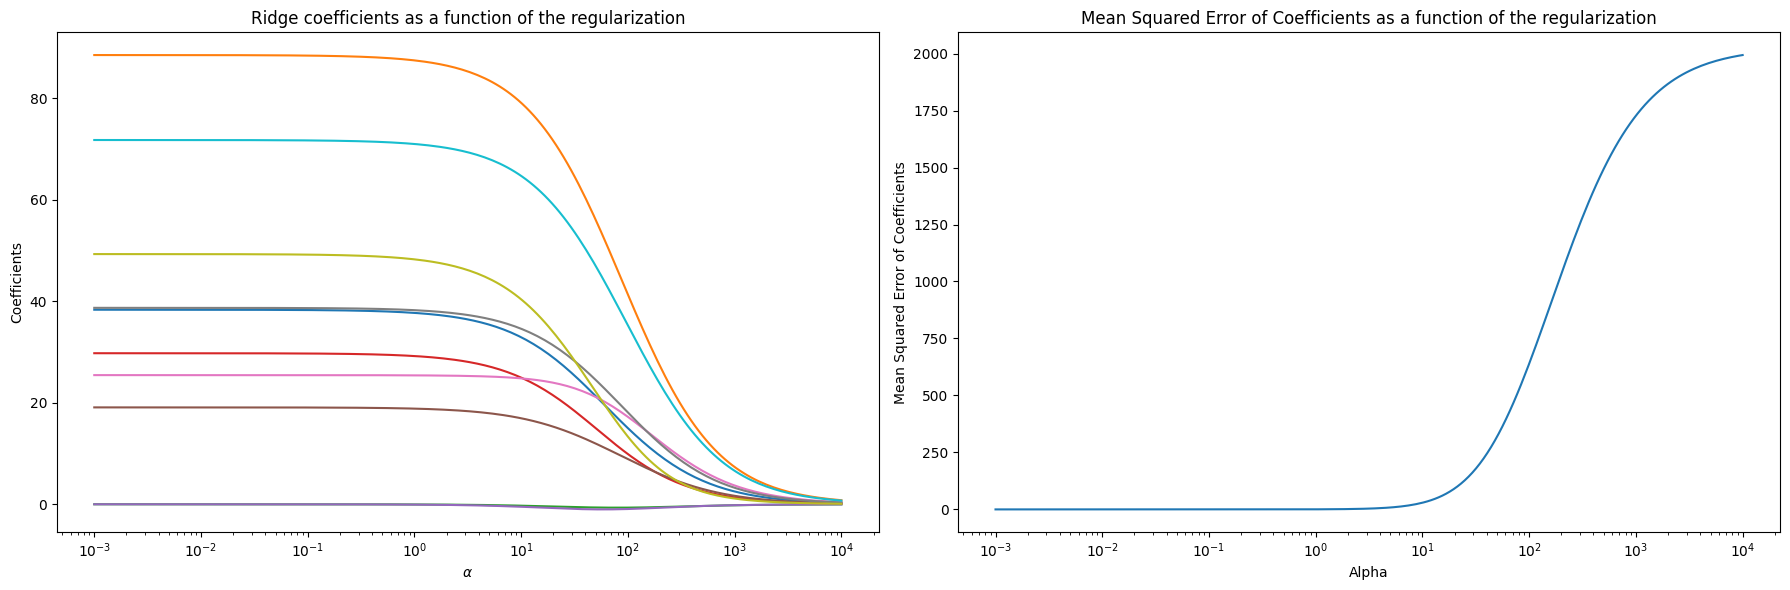

In [7]:
import matplotlib.pyplot as plt

# Generate values for `alpha` that are evenly distributed on a logarithmic scale
alphas = jnp.logspace(-3, 4, 200)
coefs = []
errors_coefs = []

# Train the model with different regularisation strengths
clf = QRidge()

for a in alphas:
    clf.set_params(alpha=a).fit(X, y)
    coefs.append(clf.coef_)
    errors_coefs.append(mean_squared_error(clf.coef_, w))

# Convert coefs list to a NumPy array for easier analysis
coefs = jnp.array(coefs)

# Plotting the coefficients as a function of the regularization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=100)

ax1.plot(alphas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel('Coefficients')
ax1.set_title('Ridge coefficients as a function of the regularization')

# Plotting the mean squared error of coefficients as a function of the regularization
ax2.plot(alphas, errors_coefs)
ax2.set_xscale('log')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Mean Squared Error of Coefficients')
ax2.set_title('Mean Squared Error of Coefficients as a function of the regularization')

plt.tight_layout()
plt.show()